In [41]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('25.csv')

# Replace negative HGB values with the mean of non-negative HGB values
non_negative_hgb_mean = df[df['HGB'] >= 0]['HGB'].mean()
df['HGB'] = df['HGB'].apply(lambda x: non_negative_hgb_mean if x < 0 else x)

# Impute numeric columns with mean
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Drop rows with missing target
df.dropna(subset=['Diagnosis'], inplace=True)

print(df[['RBC', 'HGB']].describe())  # Check the raw data before normalization

# Normalize selected numeric columns
to_normalize = ['HGB', 'RBC', 'WBC']
scaler = StandardScaler()
df[to_normalize] = scaler.fit_transform(df[to_normalize])

# Encode Diagnosis temporarily for correlation plot
df_temp = df.copy()
df_temp['Diagnosis_encoded'] = df_temp['Diagnosis'].astype('category').cat.codes

print(df['Diagnosis'].unique())  # This should show the unique labels in the 'Diagnosis' column




               RBC          HGB
count  1281.000000  1281.000000
mean      4.708267    12.201883
std       2.817200     3.762099
min       1.360000     0.400000
25%       4.190000    10.800000
50%       4.600000    12.300000
75%       5.100000    13.500000
max      90.800000    87.100000
['Normocytic hypochromic anemia' 'Iron deficiency anemia'
 'Other microcytic anemia' 'Leukemia' 'Healthy' 'Thrombocytopenia'
 'Normocytic normochromic anemia' 'Leukemia with thrombocytopenia'
 'Macrocytic anemia']


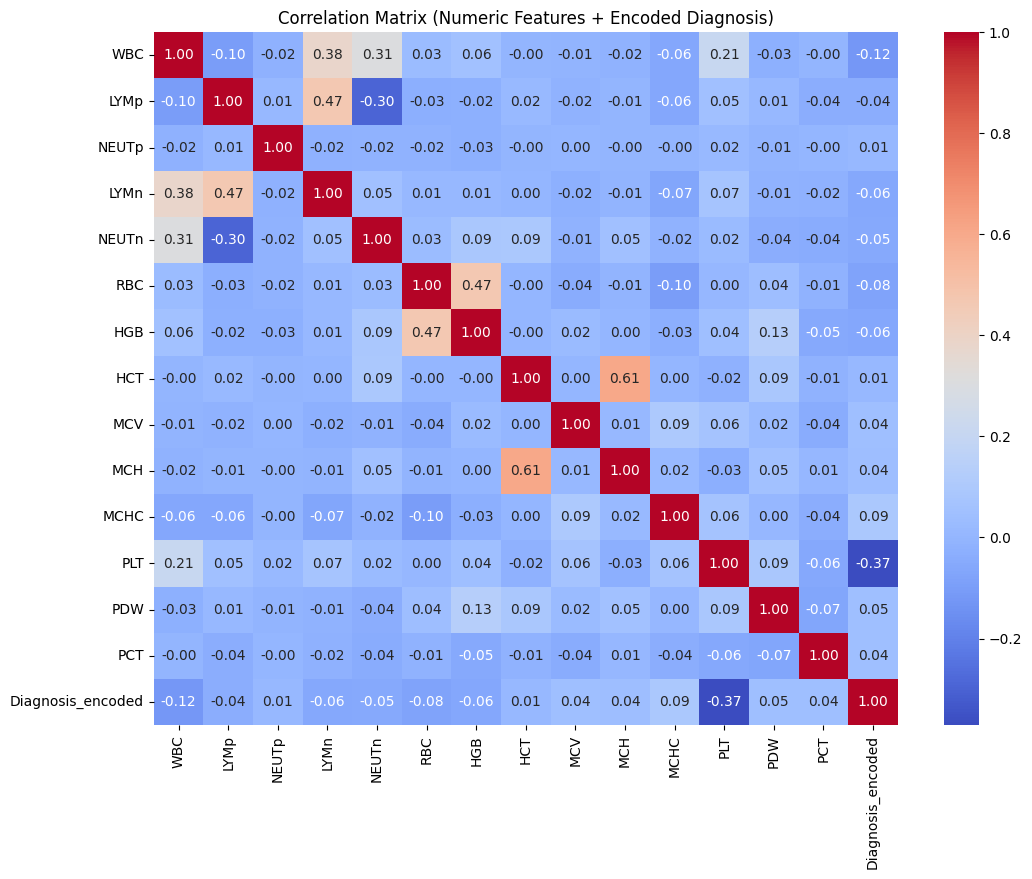

In [54]:
# Compute correlation only on numeric columns
corr = df_temp.select_dtypes(include='number').corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix (Numeric Features + Encoded Diagnosis)")
plt.show()


In [55]:
# Calculate correlation matrix
corr = df_temp.select_dtypes(include='number').corr()

# Extract correlation with Diagnosis (absolute values)
target_corr = corr['Diagnosis_encoded'].drop('Diagnosis_encoded').abs()

# Sort and display top 5 most relevant features
top_features = target_corr.sort_values(ascending=False).head(5)
print("✅ Most relevant CBC parameters for anemia classification based on correlation:")
print(top_features)


✅ Most relevant CBC parameters for anemia classification based on correlation:
PLT     0.371444
WBC     0.122703
MCHC    0.094572
RBC     0.078917
HGB     0.064022
Name: Diagnosis_encoded, dtype: float64


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# ----- 1. Select top 5 features -----
selected_features = ['PLT', 'WBC', 'MCHC', 'RBC', 'HGB']
X = df[selected_features]

# ----- 2. Encode target -----
le = LabelEncoder()
y = le.fit_transform(df['Diagnosis'])

# ----- 3. Train-test split -----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----- 4. Define classifiers -----
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(),
    'Naive Bayes': GaussianNB()
}

# ----- 5. Train & evaluate each model -----
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append((name, acc, prec, rec, f1))

# ----- 6. Display results -----
print("📊 Model Evaluation Results:")
print(f"{'Model':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
for r in results:
    print(f"{r[0]:<25} {r[1]:<10.3f} {r[2]:<10.3f} {r[3]:<10.3f} {r[4]:<10.3f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


📊 Model Evaluation Results:
Model                     Accuracy   Precision  Recall     F1-Score  
Logistic Regression       0.650      0.624      0.650      0.629     
Random Forest             0.930      0.932      0.930      0.927     
Decision Tree             0.883      0.904      0.883      0.890     
Support Vector Machine    0.463      0.411      0.463      0.408     
Naive Bayes               0.603      0.575      0.603      0.541     


<Axes: title={'center': 'Feature Importance (Random Forest)'}>

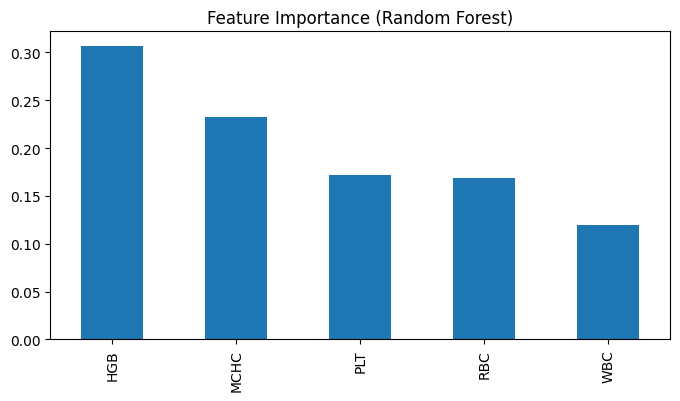

In [57]:
# Feature importance from Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=selected_features)
importances.sort_values(ascending=False).plot(kind='bar', title='Feature Importance (Random Forest)', figsize=(8,4))


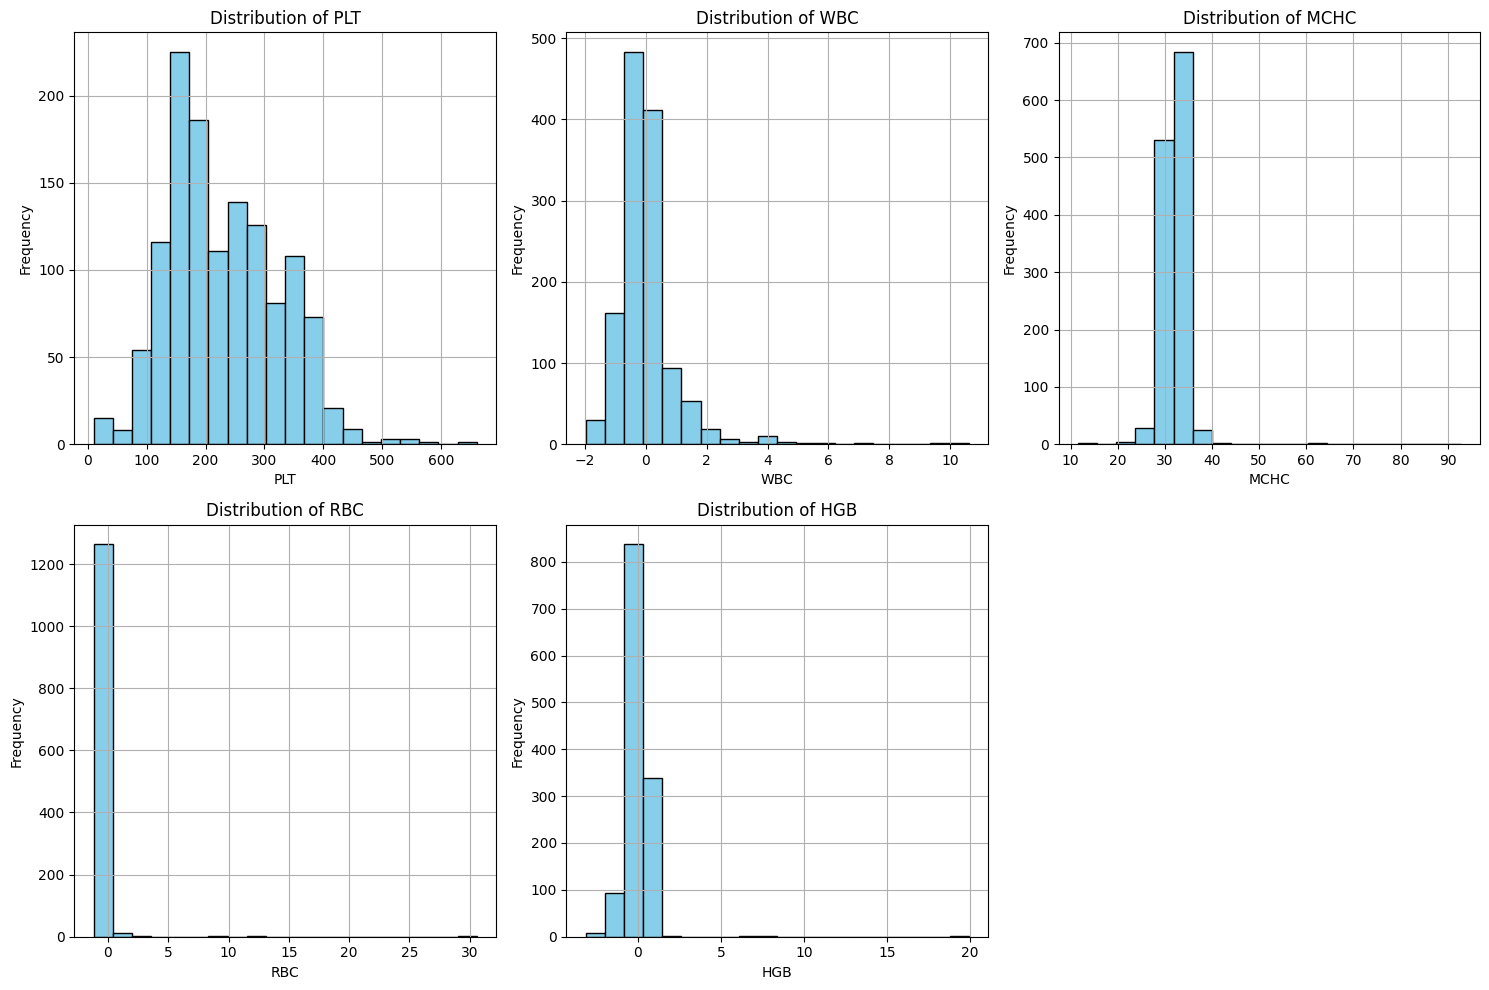

In [58]:
# Plot histograms for selected CBC parameters
plt.figure(figsize=(15, 10))

for i, col in enumerate(selected_features, 1):
    plt.subplot(2, 3, i)  # 2 rows, 3 columns
    df[col].hist(bins=20, edgecolor='black', color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


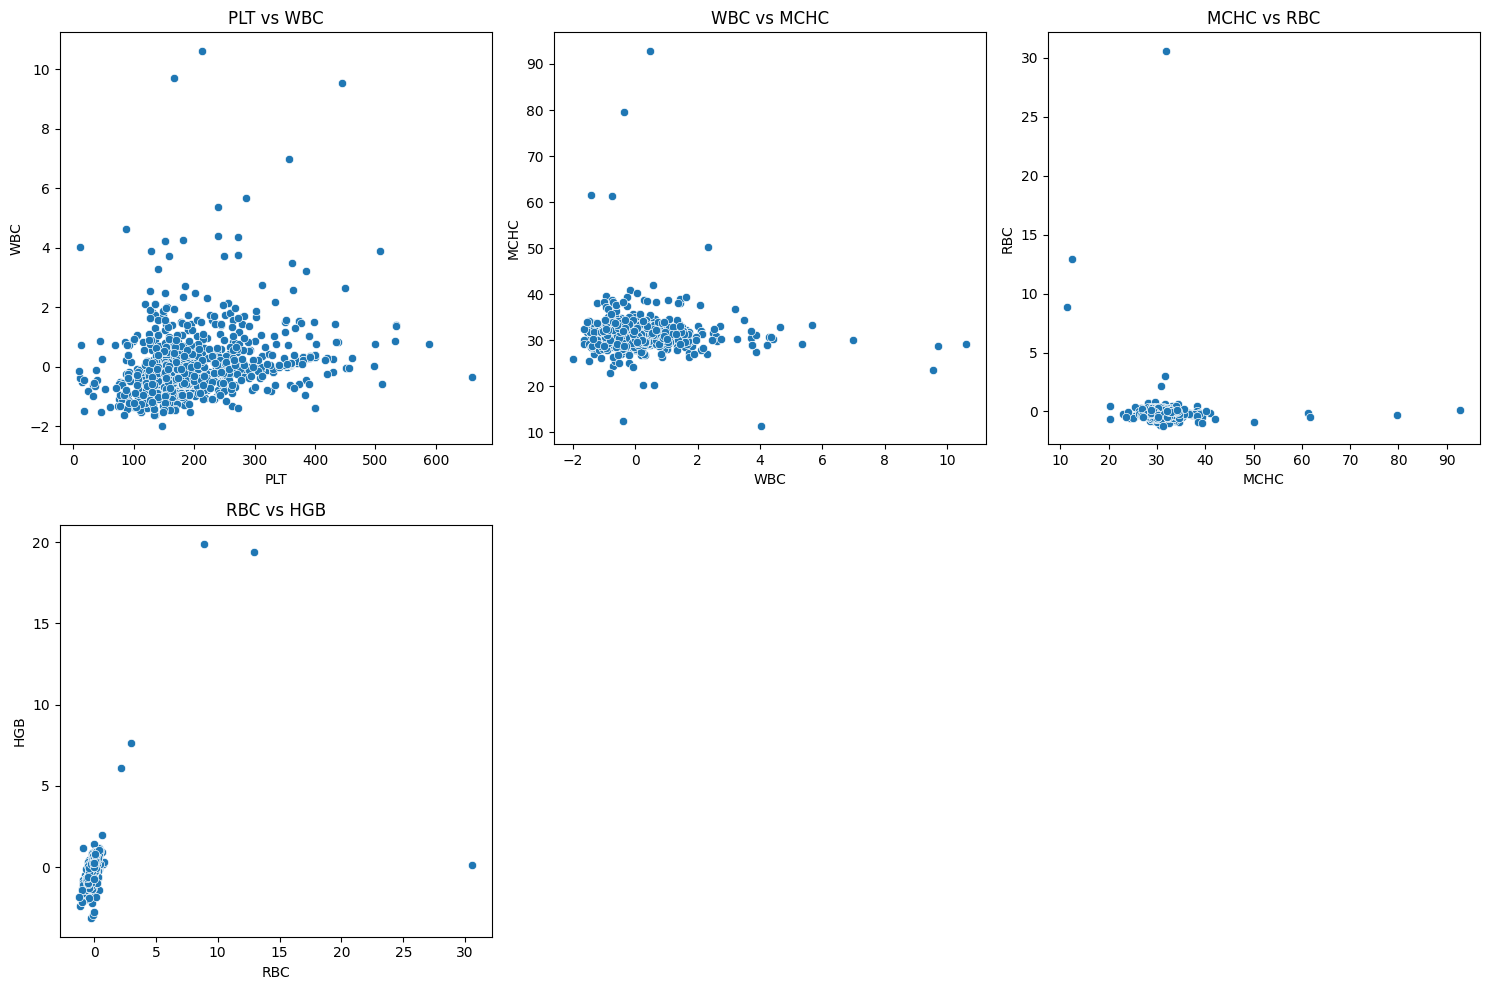

In [59]:
# Plot scatter plots for selected CBC parameters
plt.figure(figsize=(15, 10))

for i, col in enumerate(selected_features[:-1], 1):  # All except the last feature
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df, x=col, y=selected_features[i])
    plt.title(f"{col} vs {selected_features[i]}")
    plt.xlabel(col)
    plt.ylabel(selected_features[i])

plt.tight_layout()
plt.show()


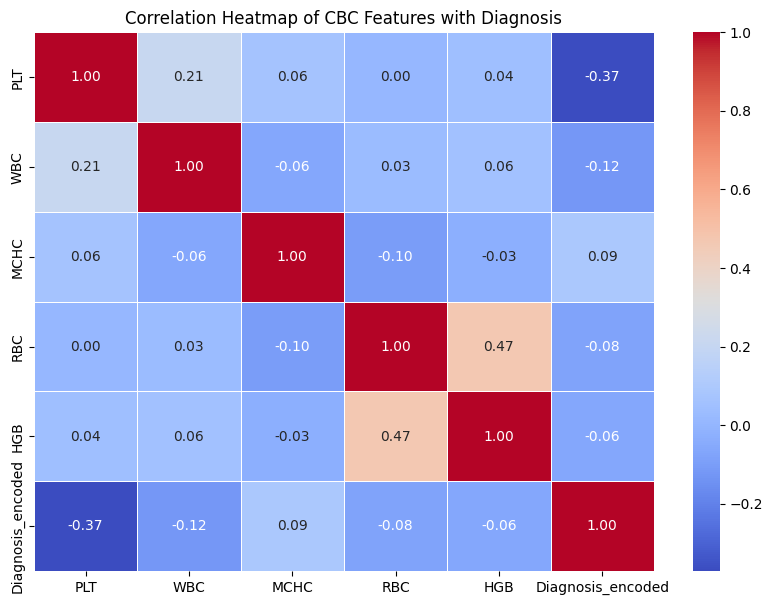

In [60]:
# Compute the correlation matrix again
corr = df_temp[selected_features + ['Diagnosis_encoded']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of CBC Features with Diagnosis")
plt.show()


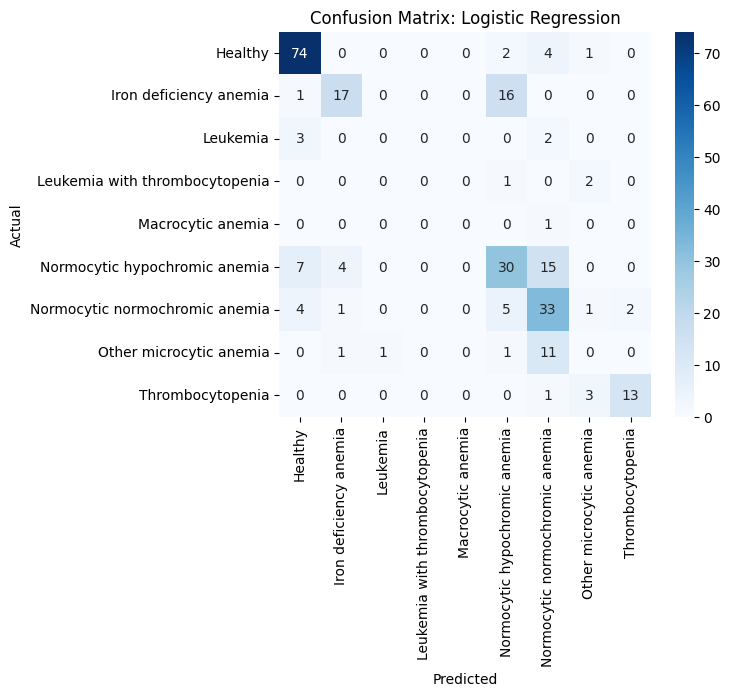

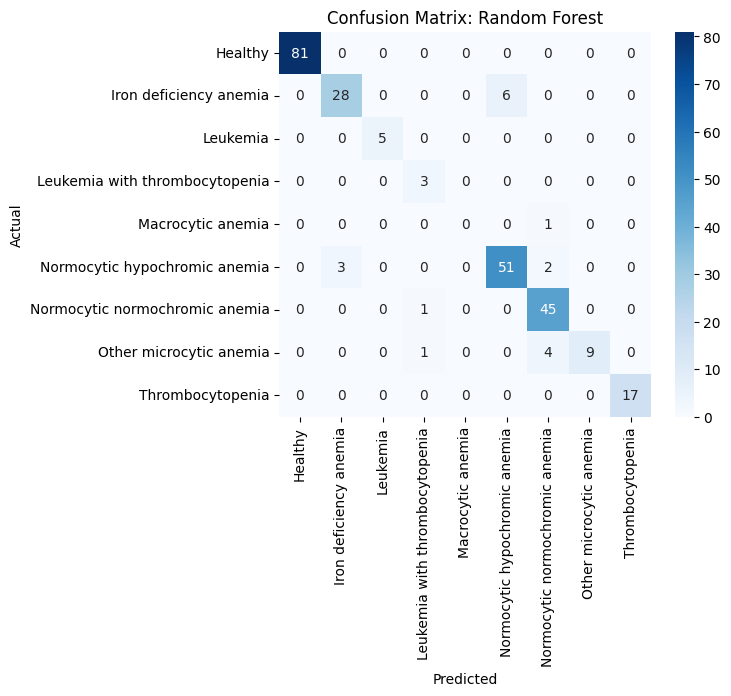

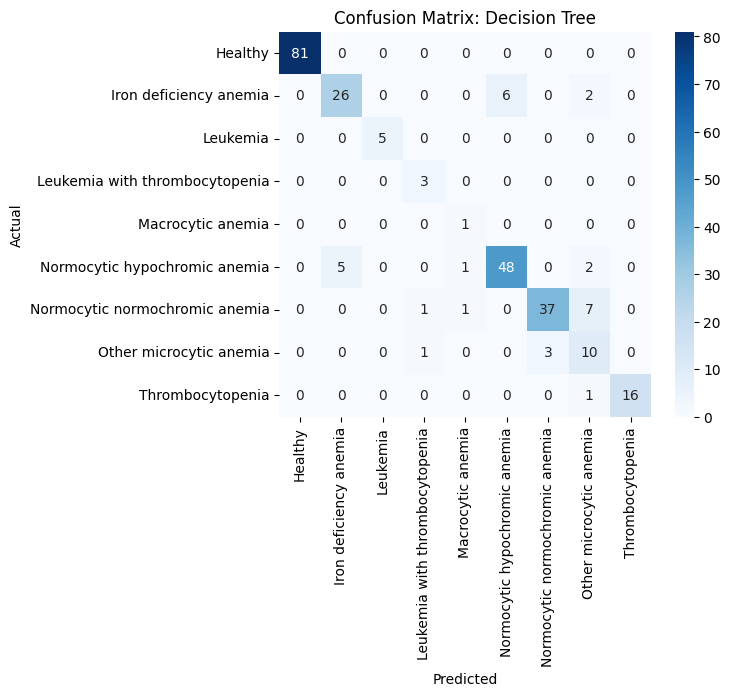

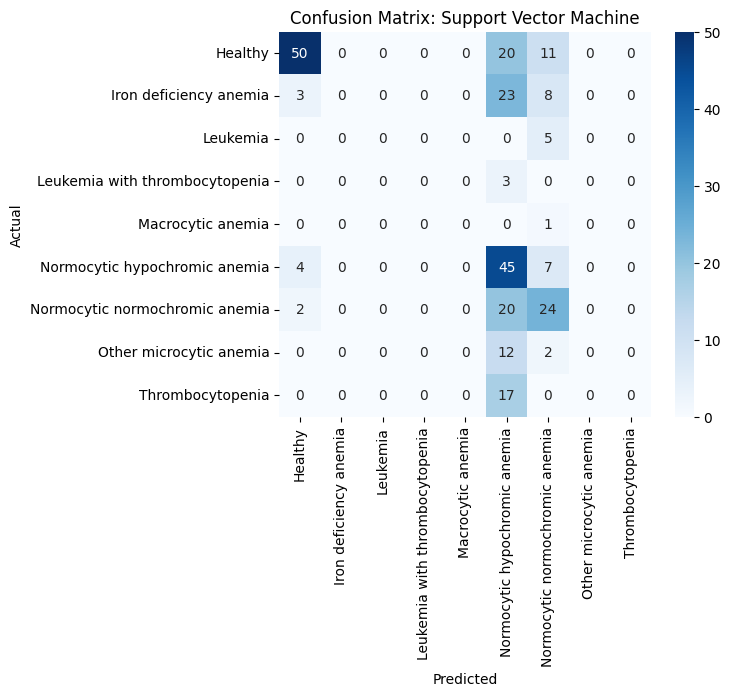

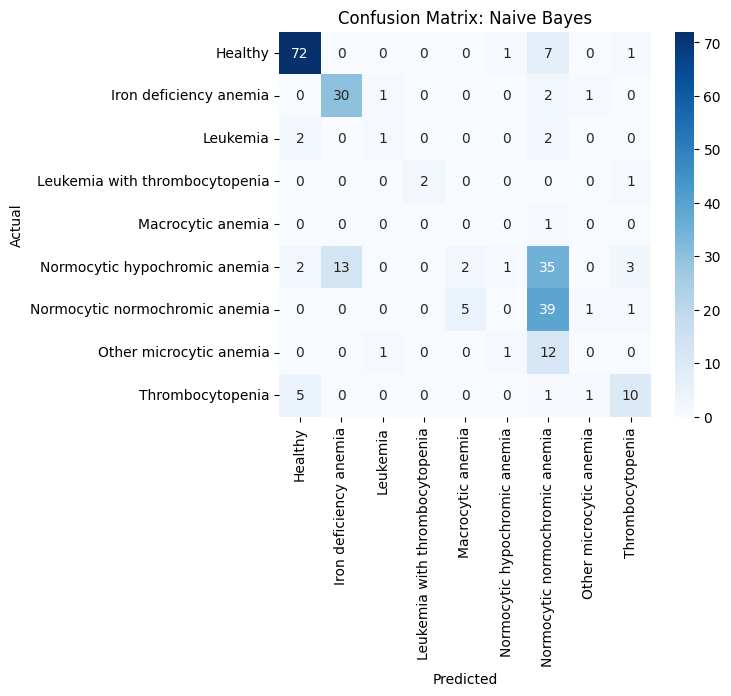

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot confusion matrices for each model
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [62]:
# Display detailed classification report
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))


📊 Classification Report for Logistic Regression:
                                precision    recall  f1-score   support

                       Healthy       0.83      0.91      0.87        81
        Iron deficiency anemia       0.74      0.50      0.60        34
                      Leukemia       0.00      0.00      0.00         5
Leukemia with thrombocytopenia       0.00      0.00      0.00         3
             Macrocytic anemia       0.00      0.00      0.00         1
 Normocytic hypochromic anemia       0.55      0.54      0.54        56
Normocytic normochromic anemia       0.49      0.72      0.58        46
       Other microcytic anemia       0.00      0.00      0.00        14
              Thrombocytopenia       0.87      0.76      0.81        17

                      accuracy                           0.65       257
                     macro avg       0.39      0.38      0.38       257
                  weighted avg       0.62      0.65      0.63       257

📊 Classifica

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [63]:
print(classification_report(y_test, y_pred, target_names=le.classes_))  # Report metrics per class


                                precision    recall  f1-score   support

                       Healthy       0.89      0.89      0.89        81
        Iron deficiency anemia       0.70      0.88      0.78        34
                      Leukemia       0.33      0.20      0.25         5
Leukemia with thrombocytopenia       1.00      0.67      0.80         3
             Macrocytic anemia       0.00      0.00      0.00         1
 Normocytic hypochromic anemia       0.33      0.02      0.03        56
Normocytic normochromic anemia       0.39      0.85      0.54        46
       Other microcytic anemia       0.00      0.00      0.00        14
              Thrombocytopenia       0.62      0.59      0.61        17

                      accuracy                           0.60       257
                     macro avg       0.47      0.45      0.43       257
                  weighted avg       0.58      0.60      0.54       257

